### Start Spark Session

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd

from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import *


from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

In [2]:
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "2g")
    .config("spark.executer.memory", "4g")
    .getOrCreate()
)

22/10/02 21:11:53 WARN Utils: Your hostname, Luo resolves to a loopback address: 127.0.1.1; using 172.29.52.230 instead (on interface eth0)
22/10/02 21:11:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/02 21:11:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Readin Data

In [3]:
full = pd.read_parquet('../data/curated/train_data/')
full = full.rename({'y_total_num_consumer': 'next_total_num_consumer', 'y_total_revenue': 'next_total_revenue', 'y_total_num_transaction': 'next_total_num_transaction'}, axis = 1)
full.dtypes

merchant_abn                    int64
total_num_consumer              int64
avg_dollar_value              float64
total_num_transaction           int64
mean_income                   float64
revenue_level                  object
total_revenue                 float64
total_num_postcode              int64
tag                            object
next_total_num_consumer       float64
next_total_revenue            float64
next_total_num_transaction    float64
dtype: object

### Clustering

tag_mean = full.groupBy(['tag')\
      .agg(
         F.mean("total_revenue").alias("mean_revenue_of_tags")
      )

tag_mean = tag_mean.toPandas()

from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=4, random_state=0).fit(np.array(tag_mean['mean_revenue_of_tags']).reshape(-1, 1))
kmeans.labels_

tag_mean['tag_labels'] = kmeans.labels_
tag_mean

tag_mean_sdf = spark.createDataFrame(tag_mean[['tag', 'tag_labels']])
tag_mean_sdf

full = full.join(tag_mean_sdf, ["tag"], how="left") 
# use left join here since if no historical data is provided, we cannot predict the future value of a merchant
full

### Data Preprocessing

In [4]:
# drop the columns not needed
consumer_df = full[['tag', 'total_num_consumer', 'total_num_transaction', 'next_total_num_consumer']]
consumer_df

,tag,total_num_consumer,total_num_transaction,next_total_num_consumer
0,furniture,808,823,980.0
1,cable,731,750,918.0
2,music,107,107,107.0
3,gift,2244,2370,2662.0
4,computer,130,130,161.0
...,...,...,...,...
3948,hobby,206,207,94.0
3949,cable,77,77,92.0
3950,digital goods,1464,1506,1669.0
3951,opticians,3920,4285,4614.0


In [5]:
# change tags into numeric feature by one hot encoding
enc = OneHotEncoder(handle_unknown='ignore')
tag_ohe = enc.fit_transform([[i] for i in consumer_df['tag']]).toarray()
tag_ohe

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
consumer_df[enc.categories_[0]] = tag_ohe
consumer_df = consumer_df.dropna()
consumer_df

,tag,total_num_consumer,total_num_transaction,next_total_num_consumer,antique,art dealer,artist supply,bicycle,books,cable,...,hobby,jewelry,motor,music,opticians,shoe,stationery,telecom,tent,watch
0,furniture,808,823,980.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,cable,731,750,918.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,music,107,107,107.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,gift,2244,2370,2662.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,computer,130,130,161.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,hobby,206,207,94.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3949,cable,77,77,92.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3950,digital goods,1464,1506,1669.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3951,opticians,3920,4285,4614.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


import six
for i in consumer_df.columns[:3]:
    if not( isinstance(consumer_df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to next_total_num_consumer for ", i, consumer_df.stat.corr('next_total_num_consumer',i))

### Visualisation

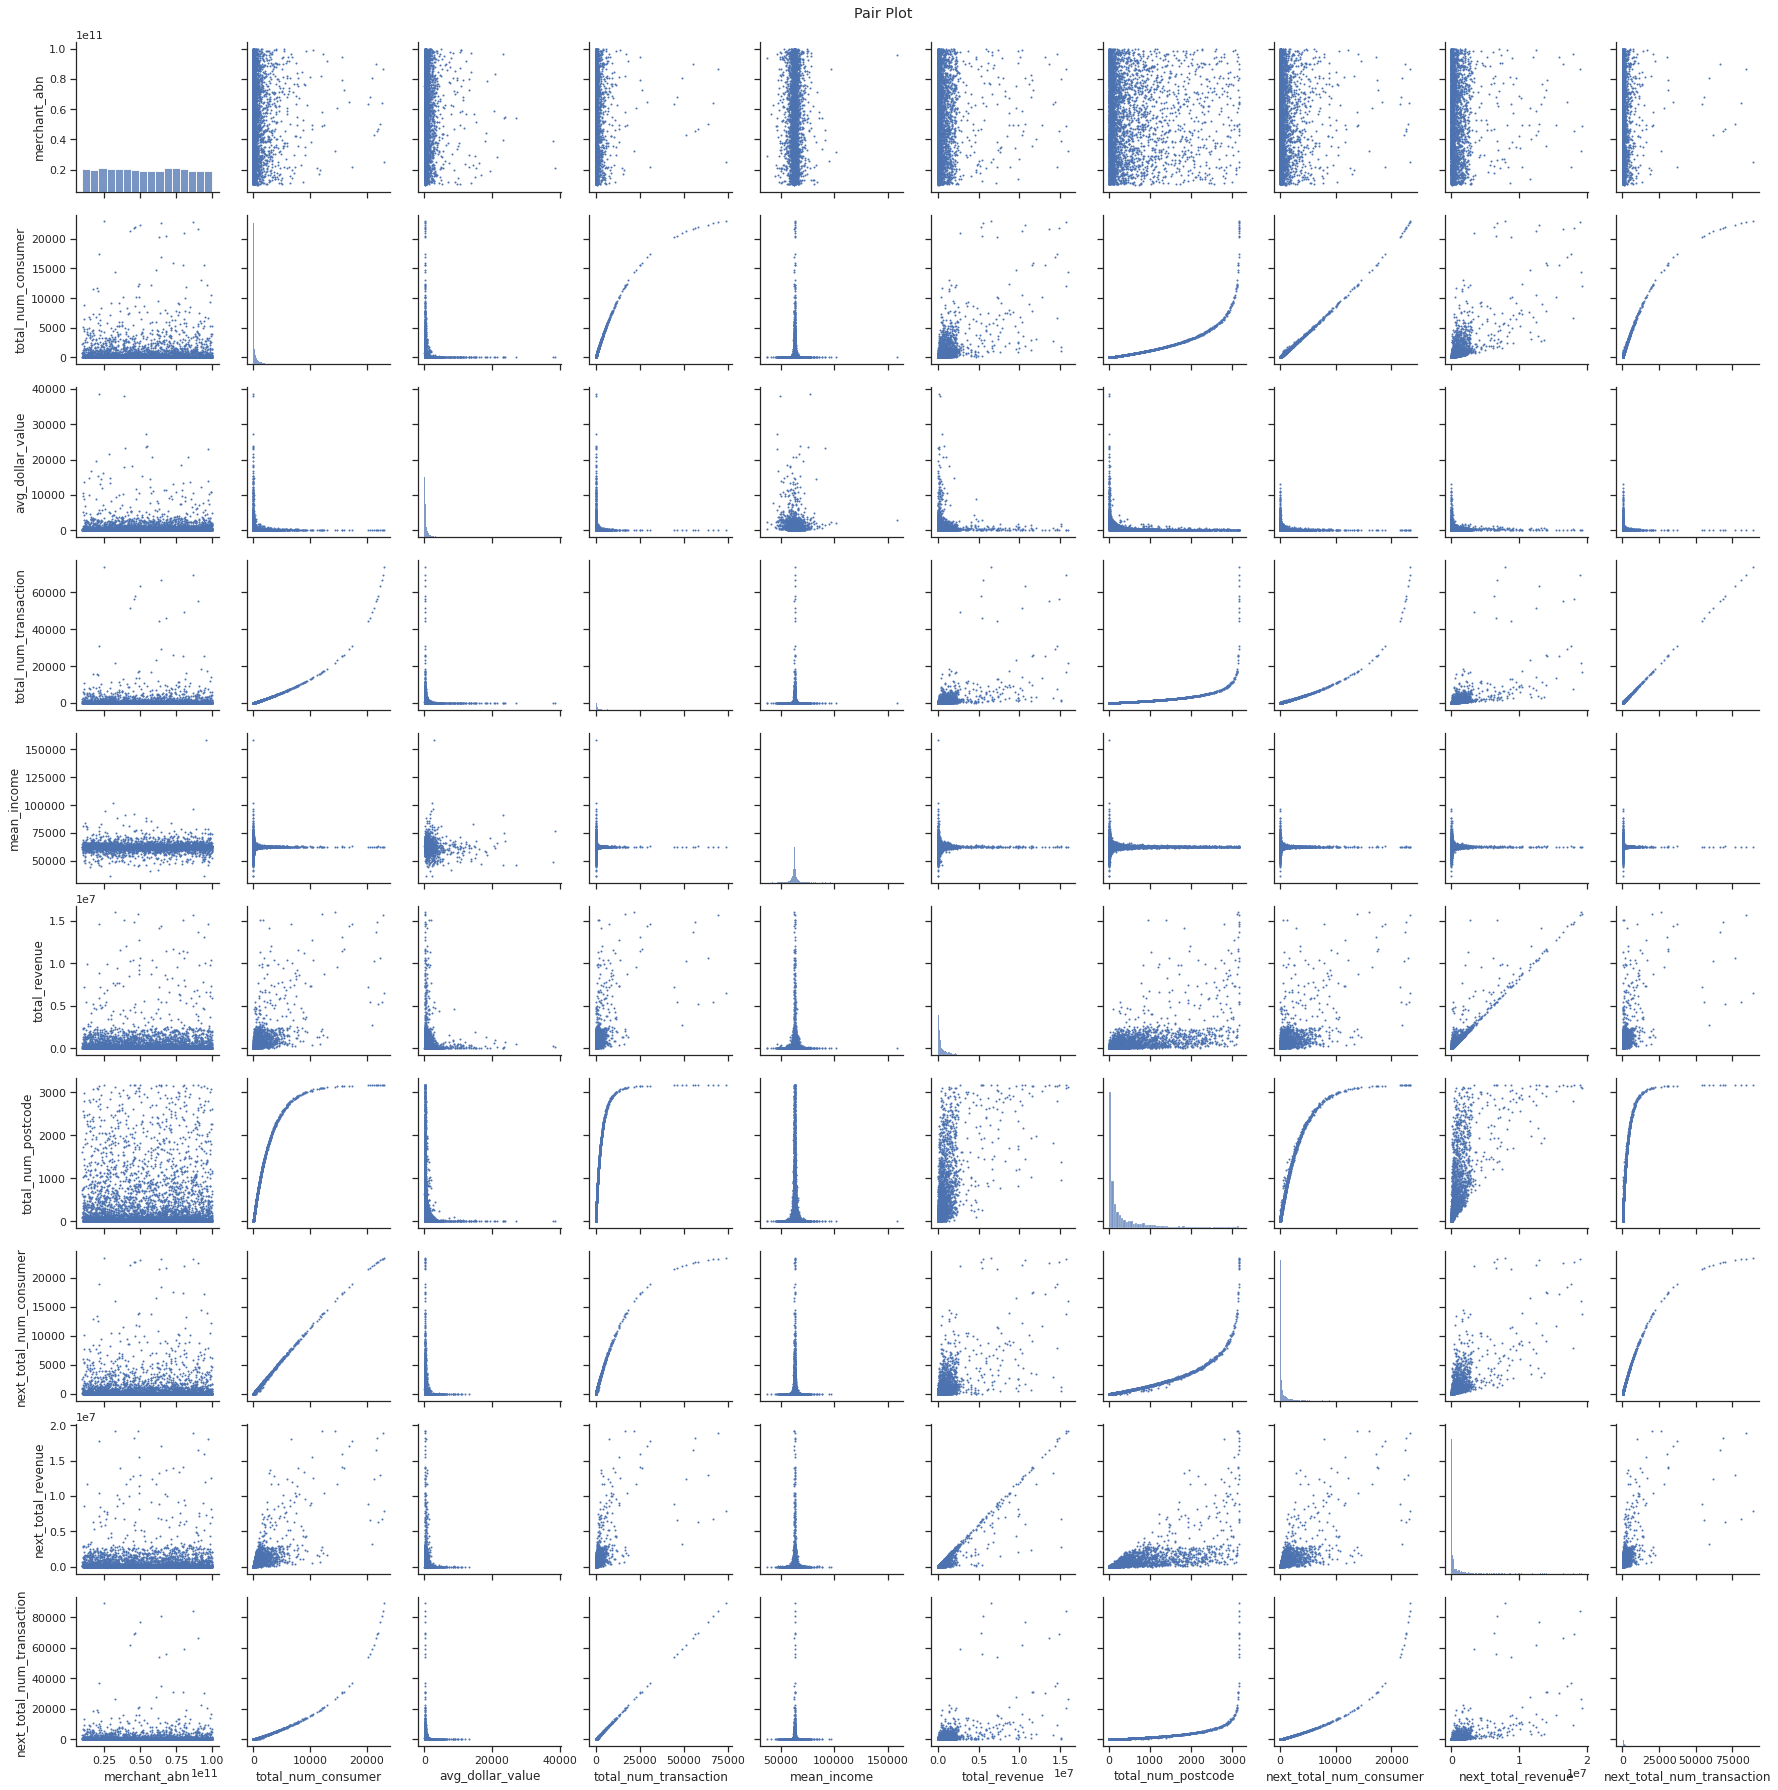

In [7]:
import seaborn as sbs
import matplotlib.pyplot as plt

sbs.set(style="ticks", color_codes=True)
g = sbs.pairplot(full, plot_kws=dict(s=1, edgecolor="b", linewidth=1),)
g.fig.suptitle("Pair Plot", y = 1)
g.fig.savefig("../plots/Pair Plot for all features.jpg")
plt.show()

### Linear Regression

In [10]:
from sklearn.linear_model import LinearRegression
import numpy as np
features = ['total_num_consumer', 'total_num_transaction']
X = np.array(consumer_df[features])
y = np.array(consumer_df['next_total_num_consumer'])
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.9990051052648128

In [11]:
from sklearn.model_selection import train_test_split
# missing values will not be included
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [28]:
lr = LinearRegression()
fitted_model = lr.fit(X_train, y_train)
fitted_model.score(X_test, y_test)

0.9990606556153125

In [25]:
print("Coefficients: %s" % str(fitted_model.coef_))
print("Intercept: %s" % str(fitted_model.intercept_))


Coefficients: [ 1.2548567  -0.07955785]
Intercept: -2.275846064876532


In [26]:
trainingSummary = fitted_model.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

AttributeError: 'LinearRegression' object has no attribute 'summary'

In [30]:
lr_predictions = fitted_model.predict(X_test)
lr_predictions

array([2.24291389e+03, 1.24656430e+02, 1.25005048e+00, ...,
       4.86241662e+03, 2.12301309e+01, 4.08919635e+02])

In [35]:
show_result = pd.DataFrame()
show_result['y_pred'] = lr_predictions
show_result['y_true'] = y_test
show_result

,y_pred,y_true
0,2242.913887,2332.0
1,124.656430,145.0
2,1.250050,3.0
3,229.098911,155.0
4,644.916030,627.0
...,...,...
1131,60.014993,71.0
1132,899.717206,861.0
1133,4862.416618,4977.0
1134,21.230131,21.0


In [38]:
from sklearn.metrics import *
print("r2 score: ", r2_score(lr_predictions, y_test))
print("Mean Absolute Error: ", mean_absolute_error(lr_predictions, y_test))

r2 score:  0.9990730702499282
Mean Absolute Error:  32.92475594779884


### Neural Network

In [40]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV

In [39]:
consumer_df

,tag,total_num_consumer,total_num_transaction,next_total_num_consumer,antique,art dealer,artist supply,bicycle,books,cable,...,hobby,jewelry,motor,music,opticians,shoe,stationery,telecom,tent,watch
0,furniture,808,823,980.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,cable,731,750,918.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,music,107,107,107.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,gift,2244,2370,2662.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,computer,130,130,161.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,hobby,206,207,94.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3949,cable,77,77,92.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3950,digital goods,1464,1506,1669.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3951,opticians,3920,4285,4614.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [55]:
consumer_df = consumer_df.drop(columns = 'tag')

In [56]:
X_train, X_test, y_train, y_test = train_test_split(consumer_df.loc[:, consumer_df.columns != 'next_total_num_consumer'], consumer_df['next_total_num_consumer'], test_size=0.3, random_state=0)
X_train.shape, X_test.shape

((2648, 26), (1136, 26))

In [57]:
# scale train and test dataset in order to be standard normally distributed with zero mean
sc_X = StandardScaler()
X_trainscaled=sc_X.fit_transform(X_train)
X_testscaled=sc_X.transform(X_test)
X_trainscaled.shape, X_testscaled.shape

((2648, 26), (1136, 26))

In [58]:
mlp_reg = MLPRegressor(hidden_layer_sizes=(128,128,128,128),activation="relu" ,solver = 'adam', random_state=30034, max_iter=20000)\
    .fit(X_trainscaled, y_train)
y_pred=mlp_reg.predict(X_testscaled)
print("The Score with ", (metrics.r2_score(y_pred, y_test)))

The Score with  0.9986929058268609


In [59]:
df_result = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_result.head()

,Actual,Predicted
558,2332.0,2312.310245
546,145.0,73.853151
2308,3.0,25.314389
2996,155.0,172.432815
807,627.0,685.279623


In [61]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.r2_score(y_test, y_pred))  

Mean Absolute Error: 36.50508002212065
Mean Squared Error: 0.9987212705319911
